<a href="https://colab.research.google.com/github/IgnacioTapiaCruz/Proyecto-FdT-grupo-4/blob/main/simulacion_grupo4_FdT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importar módulos

In [2]:
import numpy as np
import matplotlib.pyplot as plt

Inicializar varibales y parámetros del sistema

- Dimensiones tanque:

In [2]:
#Altura interna
H1 = 14 #m

#Altura externa (con aislante)
H2 = 14 + 0.75 #m

#Radio interno
R1 = 18.15 #m

#Radio externo (con aislante)
R2 = 18.15 + 0.75 #m

- Parámetros termodinámicos:

In [1]:
#Para mezcla de sales 60%NaNO3 40% KNO3
rho_sal = 1730.1 #kg/m3
cp_sal = 1540.2 #J/kgC
mu_sal = 1.11e-3 #Pa*s
k_sal = 0.55 #W/m/°C

#Temperaturas clave
#Temperatura de operación del tanque
T_0 = 565 #°C
#Temperatura en pared del tanque
T_I1 = T_0 + 273.14 #K
#Temperatura segura para hormigón del piso
TI2 = 273.15 + 90 #K
#Temperatura en seno del fluido exterior (aire)
T_inf = 273.15 + 25 #K
#Temperatura inicial aislante
T2_0 = T_I1 #K

#Flujo de calor en pared superior
q_sup = 45.0 #W/m**2
#Flujo de calor en pared lateral
q_lat = 55.0 #W/m**2

#Para aislante lana mineral en paredes
h_nat = 4.0 #W/m2/K
rho_ais = 160 #kg/m3
k_ais =  0.037 #W/m/K

1) Resolver perfil de velocidad $(0\leq r\leq R_1)$ y $(0\leq z\leq H_1)$

Las ecuaciones diferenciales que rigen el perfil de velocidad de las sales fundidas dentro del tanque son las siguientes:

- En la dirección radial:

  $
\rho v_r \frac{\partial v_r}{\partial r} + \rho v_z \frac{\partial v_r}{\partial z} = \mu \frac{\partial}{\partial r}\frac{1}{r}\frac{\partial r v_r}{\partial r} + \mu \frac{\partial^2 v_r}{\partial z^2}
$

- En la dirección axial:

  $
\rho v_r \frac{\partial v_z}{\partial r} + \rho v_z \frac{\partial v_z}{\partial z} = \frac{\mu}{r}\frac{\partial}{\partial r}r\frac{\partial v_z}{\partial r} + \mu \frac{\partial^2 v_z}{\partial z^2} + \rho g
$


Estas ecuaciones están sujetas a las siguientes condiciones de borde:
- CB1: No resbalar en piso

  $v_r(r,z=0)= 0$

- CB2: No resbalar en techo

  $v_r(r,z=H_1)= 0$

- CB3: Simetría axial, donde $v_z$ es máxima

  $\frac{\partial v_z}{\partial r}|_{r=0,z}= 0$

- CB4: No resbalar en pared lateral

  $v_z(r=R_1,z)= 0$



Para resolver este sistema de ecuaciones es necesario discretizar las EDP y las respectivas condiciones de borde. Para discretizar las EDP se usarán diferencias finitas centrales de segundo orden para segundas derivadas y diferencias finitas hacia delante de primer orden para primeras derivadas, que permiten encontrar la solución para los nodos interiores del dominio según:

$
\frac{v_{r_{i+1,j}}-2v_{r_{i,j}} + v_{r_{i-1,j}}}{\Delta r^2} + \frac{v_{r_{i,j+1}}-2v_{r_{i,j}} + v_{r_{i,j-1}}}{\Delta z^2} + (\frac{1}{r} - \frac{\rho v_r}{\mu})\frac{v_{r_{i+1,j}}-v_{r_{i,j}}}{\Delta r} - (\frac{\rho v_z}{\mu})\frac{v_{r_{i,j+1}}-v_{r_{i,j}}}{\Delta z} - \frac{v_r}{r^2} = 0
$

$
\frac{v_{z_{i+1,j}}-2v_{z_{i,j}} + v_{z_{i-1,j}}}{\Delta r^2} + \frac{v_{z_{i,j+1}}-2v_{z_{i,j}} + v_{z_{i,j-1}}}{\Delta z^2} + (\frac{1}{r} - \frac{\rho v_r}{\mu})\frac{v_{z_{i+1,j}}-v_{z_{i,j}}}{\Delta r} - (\frac{\rho v_z}{\mu})\frac{v_{z_{i,j+1}}-v_{z_{i,j}}}{\Delta z} + \frac{\rho g}{\mu} = 0
$

Las condiciones de borde discretizadas quedan de la siguiente manera:
- CB1 discretizada:

  $v_{r_{i,j=0} } = 0 \quad \forall \quad i \in [0,N_r]$
- CB2 discretizada:

  $v_{r_{i,j=N_z} } = 0 \quad \forall \quad i \in [0,N_r]$
- CB3 discretizada: por diferencias finitas hacia delante de primer orden

  $v_{z_{0,j} } = v_{z_{1,j} } \quad \forall \quad j \in [0,N_z]$
- CB4 discretizada:

  $v_{z_{i=N_r,j} } = 0 \quad \forall \quad j \in [0,N_z]$

2) Resolver perfil de temperatura acoplado a velocidad $(0\leq r\leq R_1)$ y $(0\leq z\leq H_1)$

**En primer lugar se resuelve este perfil para valores de velocidad contantes, para asegurar que este converje en el caso más sencillo (cuando las sales están quietas o se mueven de forma constante)**

La EDP que rige este perfil es:

$
\rho c_p (v_r\frac{\partial T}{\partial r} + v_z\frac{\partial T}{\partial z}) = k (\frac{1}{r}\frac{\partial}{\partial r}r\frac{\partial T}{\partial r} + \frac{\partial^2T}{\partial z^2})
$

La cual está sujeta a las siguientes condicones de borde:

- CB1: simetría axial (r=0,z)

  $\frac{\partial T}{\partial r}|_{r=0,z} = 0$

- CB2: Flux de calor en pared superior  (r, z=H1)

  $\frac{\partial T}{\partial z}|_{r,z=H_1} = \frac{-q_{sup}}{k}$

- CB3: Flux de calor en pared lateral (r=R1, z)

  $\frac{\partial T}{\partial r}|_{r=R_1,z} = \frac{-q_{lat}}{k}$

- CB4: piso adiabático (r,z=0)

  $\frac{\partial T}{\partial z}|_{r,z=0} = 0$



Al discretizar por diferencias finitas centrales de segundo orden las segundas derivadas (términos conductivos) y discretizando por diferencias finitas hacia delante de primer orden las primeras derivadas (términos convectivos) al factorizar se obtiene la siguiente ecuación a resolver:

$
(\frac{\rho c_p v_r}{\Delta r} - \frac{k}{r_{ij} \Delta r} - \frac{k}{\Delta r^2})T_{i+1,j} + (- \frac{k}{\Delta r^2})T_{i-1,j} + (\frac{\rho c_p v_z}{\Delta z}  - \frac{k}{\Delta z^2})T_{i,j+1} + (- \frac{k}{\Delta z^2})T_{i,j-1} + (-\frac{\rho c_p v_r}{\Delta r} + \frac{k}{r_{ij} \Delta r} - \frac{\rho c_p v_z}{\Delta z} +\frac{2k}{\Delta r^2}  + \frac{2k}{\Delta z^2})T_{i,j} = 0
$

Por otro lado, al discretizar las ecuaciones de borde según los siguientes criterios se obtiene:
- CB1 discretizada por diferencias finitas de 2° orden hacia delante:

  $T_{0,j}=\frac{4T_{1,j} - T_{2,j}}{3} \quad \forall \quad j \in [0,N_z]$
- CB2 discretizada por diferencias finitas de 2° orden hacia atrás:

  $T_{i,N_z} = \frac{1}{3}(\frac{-2\Delta zq_{sup}}{k} + 4T_{i,N_z-1} - 2T_{i,N_z-2}) \quad \forall\quad i \in [1,N_r]$
- CB3 discretizada por diferencias finitas de 2° orden hacia atrás:

  $T_{N_r,j} = \frac{1}{3}(\frac{-2\Delta rq_{lat}}{k} + 4T_{N_r-1,j} - 2T_{N_j-2,j}) \quad \forall\quad j \in [0,N_z-1]$
- CB4 discretizada por diferencias finitas de 2° orden hacia delante:

  $T_{i,0}=\frac{4T_{i,1} - T_{i,2}}{3} \quad \forall \quad i\in [1,N_r-1]$

De esta manera, dado a la naturaleza elíptica de la ecuación a resolver y gracias a la discretización aplicada a la EDP y sus respectivas condiciones de borde, es posible resolver el sistema mediante el método de sobre relajación sucesiva para la siguiente malla rectangular definida para todos los $i \in [0,N_r]$ y para todos los $j \in [0,N_z]$. Donde $N_r$ y $N_z$ corresponden a la cantidad de nodos entre r=0 y r=R1, y z=0 y z=H1 respectivamente.


fijar velocidades constantes: modificar estas cantidades para probar convergencia del perfil de temperatura (diverge)

In [4]:
vr = 0 #m/s
vz = 0 #m/s

Generar grilla:

In [5]:
Nr_2 = 131
Nz_2 = 101

r_grilla_2 = np.linspace(0,R1,Nr_2)
z_grilla_2 = np.linspace(0,H1,Nz_2)

dr_2 = R1/(Nr_2-1)
dz_2 = H1/(Nz_2-1)

print(dr_2, dz_2)

0.1396153846153846 0.14


Visualizar grilla:

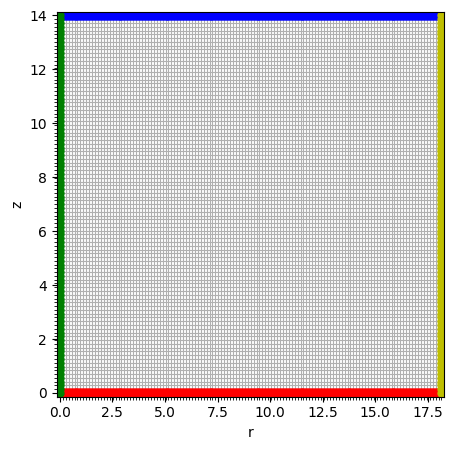

In [6]:
fig, ax = plt.subplots(figsize = (5,5))

R_2,Z_2 = np.meshgrid(r_grilla_2,z_grilla_2)

ax.plot(R_2[0,1:-1], Z_2[0,1:-1], 'r.', markersize=13) #solo interior
ax.plot(R_2[-1,1:-1], Z_2[-1,1:-1], 'b.', markersize=13) #solo interior
ax.plot(R_2[:,0], Z_2[:,0], 'g.', markersize=10)
ax.plot(R_2[:,-1], Z_2[:,-1], 'y.', markersize=10)

ax.set_xlabel('r')
ax.set_ylabel('z')
ax.set_xticks(r_grilla_2, minor=True)
ax.set_yticks(z_grilla_2, minor=True)
ax.grid(which= 'minor')

ax.set_xlim(0-dr_2,R1 + dr_2)
ax.set_ylim(0-dz_2,H1 + dz_2)

plt.show()



Definir coeficientes a, b, c, d, e y f del método SOR:

Notar que los coeficientes a y e no son constantes, ya que dependen del valor de $r_{ij}$ según la posición de la grilla en que se encuentren. Así, es necesario definir todos los valores de estos coeficientes en una matriz, para luego poder acceder a los valores específicos en cada iteración del método.

- Coeficientes constantes:

In [7]:
#nodo vecino izquierda
b_2 = -k_sal/(dr_2**2)

#nodo vecino superior
c_2 = rho_sal*cp_sal*vz/(dz_2) - k_sal/(dz_2**2)

#nodo vecino inferior
d_2 = -k_sal/(dz_2**2)

#nodo constante
f_2 = 0

print(b_2, c_2, d_2, f_2)

-28.216044744970365 -28.061224489795915 -28.061224489795915 0


- Coeficientes variables:

In [8]:
#Matriz con dimensiones de la grilla
inv_R_2 = np.ones((Nz_2, Nr_2))
#Reemplazando por valor de interés
inv_R_2[:,1:] = 1.0 / R_2[:,1:]

#Matriz nodos vecinos derecha
A_2 = (rho_sal*cp_sal*vr/(dr_2) - k_sal/(dr_2**2)) - (k_sal*inv_R_2/dr_2)
A_2 = A_2.T
#Matriz nodos centrales
E_2 = (rho_sal*cp_sal*vr/(dr_2) - rho_sal*cp_sal*vz/(dz_2) + 2*k_sal/(dr_2**2) + 2*k_sal/(dz_2**2)) + (k_sal*inv_R_2/dr_2)
E_2 = E_2.T

print(len(A_2[0,:]), len(A_2[:,0]))
print(len(E_2[0,:]), len(E_2[:,0]))

101 131
101 131


Implementación del método:

In [18]:
# parámetros SOR
omega_2 = 0.4
tol_2 = 1e-4

#iteración SOR
T = np.ones((Nr_2,Nz_2))*T_0

#condiciones de borde
#Borde izquierdo CB1
T[0,:] = (4*T[1,:] - T[2,:])/3

#Borde superior CB2
T[1:,-1] = (-2*dz_2*q_sup/k_sal + 4*T[1:,-2] - T[1:,-3])/3

#Borde derecho CB3
T[-1,:-1] = (-2*dr_2*q_lat/k_sal + 4*T[-2,:-1] - T[-3,:-1])/3

#borde inferior CB4
T[1:-1,0] = (4*T[1:-1,1] - T[1:-1,2])

#residuo total
residuo_total = 1

#contador iteraciones
cnt_it = 0
max_it = 1000

while residuo_total > tol_2 and cnt_it < max_it:
  residuo_tmp = residuo_total

  resid_total = 0
  cnt_nodos = 0

  for i in range(1, Nr_2-1):
    for j in range(1, Nz_2-1):
      a_2 = A_2[i,j]
      e_2 = E_2[i,j]
      if ((i+j)%2) == cnt_it%2:
        if (i > 0) and (i < Nr_2-1) and (j > 0) and (j < Nz_2-1):
          residuo_nodo = a_2*T[i+1,j] + b_2*T[i-1,j] + c_2*T[i,j+1] + d_2*T[i,j-1] + e_2*T[i,j] + f_2

          T[i,j] += -omega_2*residuo_nodo / e_2

          residuo_total += abs(residuo_nodo)

        cnt_nodos += 1

  #Actualizar cbs
  if cnt_it%2 == 0:
    T[0,:] = (4*T[1,:] - T[2,:])/3
    T[1:,-1] = (-2*dz_2*q_sup/k_sal + 4*T[1:,-2] - T[1:,-3])/3
    T[-1,:-1] = (-2*dr_2*q_lat/k_sal + 4*T[-2,:-1] - T[-3,:-1])/3
    T[1:-1,0] = (4*T[1:-1,1] - T[1:-1,2])

  residuo_total = residuo_total/cnt_nodos

  if cnt_it%100 == 0:
        print("Residuo total: %.3e "% residuo_total)

    # Aumentar contador de iteraciones
  cnt_it = cnt_it + 1

Residuo total: 3.269e+02 
Residuo total: 1.098e+07 
Residuo total: 2.513e+11 
Residuo total: 5.788e+15 
Residuo total: 1.338e+20 
Residuo total: 3.101e+24 
Residuo total: 7.202e+28 
Residuo total: 1.675e+33 
Residuo total: 3.902e+37 
Residuo total: 9.100e+41 


Visualizar perfil de temperatura calculado

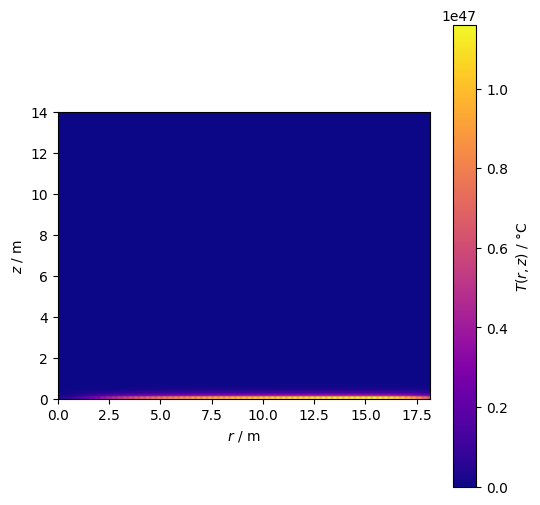

In [19]:
fig = plt.subplots(figsize=[6,6])
plt.imshow(np.flipud(np.transpose(T)), origin="upper", extent =[0,R1,0,H1], cmap = "plasma")
plt.colorbar(label=r"$T(r,z)$ / °C")
plt.xlabel(r'$r$ / m')
plt.ylabel(r'$z$ / m')

plt.show()

3.1) Resolver perfil de temperatura en pared lateral aislada $(R_1\leq r\leq R_2)$ y $(0\leq z\leq H_1)$

Para encontrar el perfil de temperatura en la pared lateral aislada $T_2(r,z)$ se discretizó la siguiente ecuación diferencial parcial, a través de diferencias finitas centrales de orden 2.
EDP original:

$
\frac{\partial^2 T_2}{\partial z^2} = \frac{-1}{r}\frac{\partial}{\partial r}(r\frac{\partial T_2}{\partial r})
$

$
\frac{\partial^2 T_2}{\partial z^2} + \frac{\partial^2 T_2}{\partial r^2} + \frac{1}{r}\frac{\partial T_2}{\partial r} = 0
$

EDP discretizada:

$
\frac{T_{i+1,j} - 2T_{i,j} + T_{i-1,j}}{\Delta r^2} + \frac{T_{i,j+1} - 2T_{i,j} + T_{i,j-1}}{\Delta z^2} + \frac{1}{r_{i,j}} \frac{T_{i+1,j} - T_{i-1,j}}{2 \Delta r} = 0
$

Aclarar que cada T corresponde a $T_2$... Factorizando se llega a:

$
\left( \frac{1}{\Delta r^2} + \frac{1}{2 r_{i,j} \Delta r} \right) T_{i+1,j} + \left( \frac{1}{\Delta r^2} - \frac{1}{2 r_{i,j} \Delta r} \right) T_{i-1,j} + \left( \frac{1}{\Delta z^2} \right) T_{i,j+1} + \left( \frac{1}{\Delta z^2} \right) T_{i,j-1} - \left( \frac{2}{\Delta r^2} + \frac{2}{\Delta z^2} \right) T_{i,j} = 0
$


Las condiciones de borde para esta parte del sistema son:

- CB1: Continuidad en interfase 1 "sal fundida - pared aislada" (R1, z)

  $
  T_2(r=R_1,z)= T_{I1}
  $
  
  - CB1 discretizada: discretización para condición de Dirichlet

    $T_{i=0,j}= T_{I1} \quad \forall j \in [0,N_z]$

- CB2: No hay transferencia de calor en interfase "aislante lateral - aislante superior" (r, H1)

  $
  \frac{\partial T_2}{\partial z}|_{r,z=H1}=0
  $
  
  - CB2 discretizada: Diferencias finitas de segundo orden hacia atrás

    $T_{i, N_z} = \frac{4T_{i, N_z-1} - 2T_{i, N_z-2}}{3} \quad \forall \quad i \in [1, N_r-1]$

- CB3: Borde inferior adiabático (r, 0)

  $\frac{\partial T_2}{\partial z}|_{r,z=0}=0$

  - CB3 discretizada: Diferencias finitas de segundo orden hacia delante

    $T_{i, 0} = \frac{4T_{i, 1} - 2T_{i, 2}}{3} \quad \forall \quad i \in [1, N_r-1]$
  

- CB4: Convección natural en pared exterior (R2, z)

  $-k_2\frac{\partial T_2}{\partial r}|_{r=R_2,z}=h_{nat}(T_2(R_2,z)-T_{\infty, air})$

  - CB4 discretizada: Diferencias finitas de segundo orden hacia atrás
    $T_{N_r, j} = \frac{1}{\left( 3 + \frac{2 \Delta r h_{nat}}{k_2} \right)} \left( 4 T_{N_r-1, j} - T_{N_r-2, j} + \frac{2 \Delta r h_{nat}}{k_2} T_{\infty, air} \right) \quad \forall \quad j \in [0, N_z]$

De esta manera, se puede buscar el perfil en cuestión con el método SOR dentro de la grilla definida para $i\in [0,N_r]$ y $j \in [0,N_z]$:

Generación de la grilla


In [11]:
Nr_31 = 51
Nz_31 = 101

r_grilla_31 = np.linspace(0,R2-R1,Nr_31)
z_grilla_31 = np.linspace(0,H1,Nz_31)

dr_31 = (R2-R1)/(Nr_31-1)
dz_31 = H1/(Nz_31-1)

print(dr_31, dz_31)

0.015 0.14


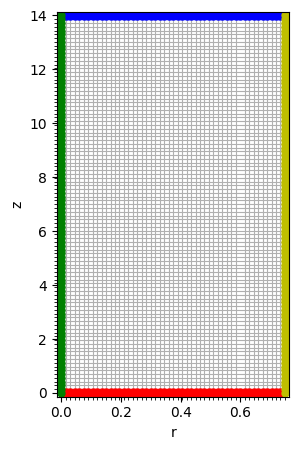

In [12]:
fig, ax = plt.subplots(figsize = (3,5))

R,Z = np.meshgrid(r_grilla_31,z_grilla_31)

ax.plot(R[0,1:-1], Z[0,1:-1], 'r.', markersize=13) #solo interior
ax.plot(R[-1,1:-1], Z[-1,1:-1], 'b.', markersize=13) #solo interior
ax.plot(R[:,0], Z[:,0], 'g.', markersize=10)
ax.plot(R[:,-1], Z[:,-1], 'y.', markersize=10)

ax.set_xlabel('r')
ax.set_ylabel('z')
ax.set_xticks(r_grilla_31, minor=True)
ax.set_yticks(z_grilla_31, minor=True)
ax.grid(which= 'minor')

ax.set_xlim(0-dr_31,R2 - R1 + dr_31)
ax.set_ylim(0-dz_31,H1 + dz_31)

plt.show()

Definir coeficientes independientes a T.

Los coeficientes $a_{ij}$ y $b_{ij}$ no son constantes por lo que es necesario definirlos para todos los nodos interiores i y j (matricialmente) para luego extraer el valor de estos en cada iteración del método SOR para los respectivos ij

coeficientes variables:

In [13]:
#Matriz con dimensiones de la grilla
inv_R = np.ones((Nz_31,Nr_31))
#Reemplazando por valor de interés
inv_R[:,1:] = 1.0 / R[:,1:]

A = (1/dr_31**2) + (1*inv_R/(2*dr_31))
A = A.T
B = (1/dr_31**2) - (1*inv_R/(2*dr_31))
B = B.T

coeficientes constantes:

In [14]:
#nodo vecino superior
c = 1/dz_31**2
#nodo vecino inferior
d = 1/dz_31**2
#nodo central
e = -(2/dr_31**2)-(2/dz_31**2)
#término constante
f = 0

Implementación del método

In [15]:
# parámetros SOR
omega_31 = 1.8
tol_31 = 1e-4

#iteración SOR
T2 = np.ones((Nr_31,Nz_31))*T2_0

#condiciones de borde
#Borde izquierdo CB1
T2[0,:] = T_I1

#Borde superior CB2
T2[1:-1,-1] = (4*T2[1:-1,-2] - T2[1:-1,-3])/3

#Borde inferior CB3
T2[1:-1,0] = (4*T2[1:-1,1] - T2[1:-1,2])/3

#borde derecho CB4
T2[-1,:] = 1/(3+(2*dr_31*h_nat/k_ais))*(4*T2[-2,:]-2*T2[-3,:]+(2*dr_31*h_nat/k_ais)*T_inf)

#residuo total
residuo_total = 1

#contador iteraciones
cnt_it = 0

while residuo_total > tol_31:
  residuo_tmp = residuo_total

  resid_total = 0
  cnt_nodos = 0

  for i in range(1, Nr_31-1):
    for j in range(1, Nz_31-1):
      a = A[i,j]
      b = B[i,j]
      if ((i+j)%2) == cnt_it%2:
        if (i > 0) and (i < Nr_31-1) and (j > 0) and (j < Nz_31-1):
          residuo_nodo = a*T2[i+1,j] + b*T2[i-1,j] + c*T2[i,j+1] + d*T2[i,j-1] + e*T2[i,j] + f

          T2[i,j] += -omega_31*residuo_nodo / e

          residuo_total += abs(residuo_nodo)

        cnt_nodos += 1

  #Actualizar cbs
  if cnt_it%2 == 0:
    T2[0,:] = T_I1
    T2[1:-1,-1] = (4*T2[1:-1,-2] - T2[1:-1,-3])/3
    T2[1:-1,0] = (4*T2[1:-1,1] - T2[1:-1,2])/3
    T2[-1,:] = 1/(3+(2*dr_31*h_nat/k_ais))*(4*T2[-2,:]-2*T2[-3,:]+(2*dr_31*h_nat/k_ais)*T_inf)

  residuo_total = residuo_total/cnt_nodos

  if cnt_it%100 == 0:
        print("Residuo total: %.3e "% residuo_total)

    # Aumentar contador de iteraciones
  cnt_it = cnt_it + 1



Residuo total: 3.838e+04 
Residuo total: 1.853e+04 
Residuo total: 4.631e+03 
Residuo total: 1.158e+03 
Residuo total: 2.896e+02 
Residuo total: 7.241e+01 
Residuo total: 1.811e+01 
Residuo total: 4.529e+00 
Residuo total: 1.133e+00 
Residuo total: 2.833e-01 
Residuo total: 7.086e-02 
Residuo total: 1.772e-02 
Residuo total: 4.434e-03 
Residuo total: 1.109e-03 
Residuo total: 2.774e-04 


Visualizar solución perfil de temperatura T2

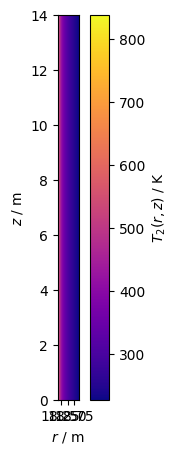

In [22]:
fig = plt.subplots(figsize=[3,5])
plt.imshow(np.flipud(np.transpose(T2)), origin="upper", extent =[R1,R2,0,H1], cmap = "plasma")
plt.colorbar(label=r"$T_2(r,z)$ / K")
plt.xlabel(r'$r$ / m')
plt.ylabel(r'$z$ / m')

plt.show()

